# 7. Telling birds from airplanes: Learning from images
This chapter covers
* Building a feed-forward neural network
* Loading data using Dataset s and DataLoader s
* Understanding classification loss

In this chapter, we’ll keep moving ahead with building our neural network foundations. This time, we’ll turn our attention to images. Image recognition is arguably the task that made the world realize the potential of deep learning.

We will approach a simple image recognition problem step by step, building from
a simple neural network like the one we defined in the last chapter. This time, instead
of a tiny dataset of numbers, we’ll use a more extensive dataset of tiny images. Let’s
download the dataset first and get to work preparing it for use.

## 7.1 A dataset of tiny images
There is nothing like an intuitive understanding of a subject, and there is nothing to
achieve that like working on simple data. One of the most basic datasets for image
recognition is the handwritten digit-recognition dataset known as **MNIST**. Here
we will use another dataset that is similarly simple and a bit more fun. It’s called
CIFAR-10, and, like its sibling **CIFAR-100**, it has been a computer vision classic for
a decade.

CIFAR-10 consists of 60,000 tiny 32 × 32 color (RGB) images, labeled with an inte-
ger corresponding to 1 of 10 classes: airplane (0), automobile (1), bird (2), cat (3),
deer (4), dog (5), frog (6), horse (7), ship (8), and truck (9). Nowadays, **CIFAR-10** is
considered too simple for developing or validating new research, but it serves our
learning purposes just fine. We will use the `torchvision` module to automatically
download the dataset and load it as a collection of PyTorch tensors. Figure 7.1 gives us
a taste of **CIFAR-10**.

![](images/7.1.png)

## 7.1.1 Downloading CIFAR-10
As we anticipated, let’s import `torchvision` and use the `datasets` module to download the CIFAR-10 data:

In [1]:
from torchvision import datasets

data_path = './data-unversioned/p1ch7/'
# Instantiates a dataset for the training data; 
# TorchVision downloads the data if it is not present.
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
# With train=False, this gets us a dataset for the validation data, again downloading as necessary.
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


The first argument we provide to the `CIFAR10` function is the location from which the
data will be downloaded; the second specifies whether we’re interested in the training
set or the validation set; and the third says whether we allow PyTorch to download the
data if it is not found in the location specified in the first argument.

Just like `CIFAR10` , the `datasets` submodule gives us precanned access to the most
popular computer vision datasets, such as MNIST, Fashion-MNIST, CIFAR-100,
SVHN, Coco, and Omniglot. In each case, the dataset is returned as a subclass of
`torch.utils.data.Dataset` . We can see that the method-resolution order of our
`cifar10` instance includes it as a base class:

In [2]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

### 7.1.2 The Dataset class
It’s a good time to discover what being a subclass of torch.utils.data.Dataset
means in practice. Looking at figure 7.2, we see what PyTorch Dataset is all about. It
is an object that is required to implement two methods: `__len__` and `__getitem__` .
The former should return the number of items in the dataset; the latter should return
the item, consisting of a sample and its corresponding label (an integer index).

In practice, when a Python object is equipped with the `__len__` method, we can
pass it as an argument to the len Python built-in function:

In [3]:
len(cifar10)

50000

![](images/7.2.png)

Similarly, since the dataset is equipped with the `__getitem__` method, we can use the
standard subscript for indexing tuples and lists to access individual items. Here, we get
a **PIL** (Python Imaging Library, the PIL package) image with our desired output—an
integer with the value 1 , corresponding to “automobile”:

In [4]:
img, label = cifar10[99]
img, label

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F56A6AFC070>, 1)

So, the sample in the `data.CIFAR10` dataset is an instance of an RGB PIL image. We
can plot it right away:

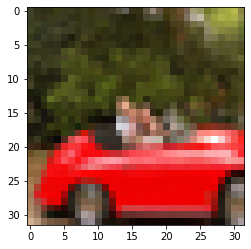

In [5]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.show()

### 7.1.3 Dataset transforms
That’s all very nice, but we’ll likely need a way to convert the PIL image to a PyTorch
tensor before we can do anything with it. That’s where `torchvision.transforms`
comes in. This module defines a set of composable, function-like objects that can be
passed as an argument to a `torchvision` dataset such as `datasets.CIFAR10(...)` , and
that perform transformations on the data after it is loaded but before it is returned by
`__getitem__` . We can see the list of available objects as follows:

In [6]:
from torchvision import transforms
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

Among those transforms, we can spot `ToTensor` , which turns NumPy arrays and PIL
images to tensors. It also takes care to lay out the dimensions of the output tensor as
C × H × W (channel, height, width; just as we covered in chapter 4).

Let’s try out the `ToTensor` transform. Once instantiated, it can be called like a
function with the PIL image as the argument, returning a tensor as output:

In [7]:
from torchvision import transforms
import torch

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

As we anticipated, we can pass the transform directly as an argument to `dataset.CIFAR10` :

In [8]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

At this point, accessing an element of the dataset will return a tensor, rather than a
PIL image:

In [9]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

As expected, the shape has the channel as the first dimension, while the scalar type is `float32` :

In [10]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

Whereas the values in the original PIL image ranged from 0 to 255 (8 bits per channel), the `ToTensor` transform turns the data into a 32-bit floating-point per channel,
scaling the values down from 0.0 to 1.0. Let’s verify that:

In [11]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

And let’s verify that we’re getting the same image out:

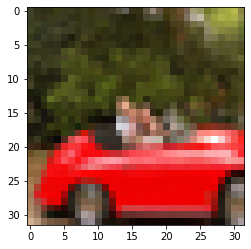

In [12]:
plt.imshow(img_t.permute(1,2,0)) #Changes the order of the axes from C × H × W to H × W × C
plt.show()

It checks. Note how we have to use `permute` to change the order of the axes from
C × H × W to H × W × C to match what Matplotlib expects.

### 7.1.4 Normalizing data
Transforms are really handy because we can chain them using transforms.Compose ,
and they can handle normalization and data augmentation transparently, directly in
the data loader. For instance, it’s good practice to normalize the dataset so that each
channel has zero mean and unitary standard deviation. We mentioned this in chapter
4, but now, after going through chapter 5, we also have an intuition for why: by choosing
activation functions that are linear around 0 plus or minus 1 (or 2), keeping the data
in the same range means it’s more likely that neurons have nonzero gradients and, hence, will learn sooner. Also, normalizing each channel so that it has the same
distribution will ensure that channel information can be mixed and updated through
gradient descent using the same learning rate. This is just like the situation in section
5.4.4 when we rescaled the weight to be of the same magnitude as the bias in our
temperature-conversion model.

In order to make it so that each channel has zero mean and unitary standard devi-
ation, we can compute the mean value and the standard deviation of each channel
across the dataset and apply the following transform: `v_n[c] = (v[c] - mean[c]) / stdev[c]` . This is what `transforms.Normalize` does. The values of `mean` and `stdev`
must be computed offline (they are not computed by the transform). Let’s compute
them for the CIFAR-10 training set.

Since the CIFAR-10 dataset is small, we’ll be able to manipulate it entirely in memory. Let’s stack all the tensors returned by the dataset along an extra dimension:

In [13]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

Now we can easily compute the mean per channel:

In [14]:
imgs.view(3, -1).mean(dim=1)
# Recall that view(3, -1) keeps the three channels and
# merges all the remaining dimensions into one, figuring
# out the appropriate size. Here our 3 × 32 × 32 image is
# transformed into a 3 × 1,024 vector, and then the mean
# is taken over the 1,024 elements of each channel.

tensor([0.4914, 0.4822, 0.4465])

With these numbers in our hands, we can initialize the `Normalize` transform

Computing the standard deviation is similar:

In [15]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

With these numbers in our hands, we can initialize the `Normalize` transform

In [16]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

and concatenate it after the `ToTensor` transform:

In [17]:
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Note that, at this point, plotting an image drawn from the dataset won’t provide us
with a faithful representation of the actual image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


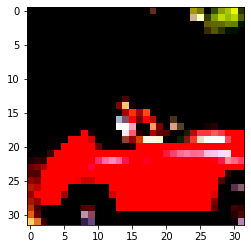

In [18]:
img_t, _ = cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

## 7.2 Distinguishing birds from airplanes
Jane, our friend at the bird-watching club, has set up a fleet of cameras in the woods
south of the airport. The cameras are supposed to save a shot when something enters
the frame and upload it to the club’s real-time bird-watching blog. The problem is
that a lot of planes coming and going from the airport end up triggering the camera, so Jane spends a lot of time deleting pictures of airplanes from the blog. What she
needs is an automated system like that shown in figure 7.6. Instead of manually deleting, she needs a neural network—an AI if we’re into fancy marketing speak—to throw
away the airplanes right away.

![](images/7.3.png)

No worries! We’ll take care of that, no problem—we just got the perfect dataset for
it (what a coincidence, right?). We’ll pick out all the birds and airplanes from our
CIFAR-10 dataset and build a neural network that can tell birds and airplanes apart.

### 7.2.1 Building the dataset
The first step is to get the data in the right shape. We could create a `Dataset` subclass
that only includes birds and airplanes. However, the dataset is small, and we only need
indexing and `len` to work on our dataset. It doesn’t actually have to be a subclass of
`torch.utils.data.dataset.Dataset` ! Well, why not take a shortcut and just filter the
data in `cifar10` and remap the labels so they are contiguous? Here’s how:

In [19]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(img, label_map[label])
    for img, label in cifar10
    if label in [0, 2]]

cifar2_val = [(img, label_map[label])
    for img, label in cifar10_val
    if label in [0, 2]]

The `cifar2` object satisfies the basic requirements for a `Dataset` —that is, `__len__` and `__getitem__` are defined—so we’re going to use that. We should be aware, however,
that this is a clever shortcut and we might wish to implement a proper `Dataset` if we
hit limitations with it.

### 7.2.2 A fully connected model
We learned how to build a neural network in chapter 5. We know that it’s a tensor of
features in, a tensor of features out. After all, an image is just a set of numbers laid out
in a spatial configuration. OK, we don’t know how to handle the spatial configuration
part just yet, but in theory if we just take the image pixels and straighten them into a
long 1D vector, we could consider those numbers as input features, right? This is what
figure 7.7 illustrates.

![](images/7.4.png)

How many features per sample? Well, 32 × 32 × 3: that is, 3,072 input
features per sample. Starting from the model we built in chapter 5, our new model
would be an `nn.Linear` with 3,072 input features and some number of hidden features, followed by an activation, and then another `nn.Linear` that tapers the network down to
an appropriate output number of features (2, for this use case):

In [20]:
import torch.nn as nn

n_out = 2

model = nn.Sequential(
    nn.Linear(
        3072,  # Input features
        512,   # hidden layer size
    ),
    nn.Tanh(),
    nn.Linear(
        512,   # Hidden layer size
        n_out, # Output classes
    ) 
)

We somewhat arbitrarily pick 512 hidden features. A neural network needs at least
one hidden layer (of activations, so two modules) with a nonlinearity in between in
order to be able to learn arbitrary functions in the way we discussed in section 6.3—
otherwise, it would just be a linear model. The hidden features represent (learned)
relations between the inputs encoded through the weight matrix. As such, the model
might learn to “compare” vector elements 176 and 208, but it does not a priori focus
on them because it is structurally unaware that these are, indeed (row 5, pixel 16) and
(row 6, pixel 16), and thus adjacent.

### 7.2.3 Output of a classifier
In chapter 6, the network produced the predicted temperature (a number with a quantitative meaning) as output. We could do something similar here: make our network output a single scalar value (so n_out = 1 ), cast the labels to floats (0.0 for airplane and 1.0 for bird), and use those as a target for MSELoss (the average of squared differences in the batch). Doing so, we would cast the problem into a regression problem. However, looking more closely, we are now dealing with something a bit different in nature.

We need to recognize that the output is categorical: it’s either a bird or an airplane (or something else if we had all 10 of the original classes). As we learned in
chapter 4, when we have to represent a categorical variable, we should switch to a
one-hot-encoding representation of that variable, such as [1, 0] for airplane or [0, 1] for bird (the order is arbitrary). This will still work if we have 10 classes, as in the full
CIFAR-10 dataset; we’ll just have a vector of length 10.

In the ideal case, the network would output torch.tensor([1.0, 0.0]) for an airplane and torch.tensor([0.0, 1.0]) for a bird. Practically speaking, since our classifier will not be perfect, we can expect the network to output something in between. The key realization in this case is that we can interpret our output as probabilities: the first entry is the probability of “airplane,” and the second is the probability of “bird.”

Casting the problem in terms of probabilities imposes a few extra constraints on
the outputs of our network:
* Each element of the output must be in the [0.0, 1.0] range (a probability of an outcome cannot be less than 0 or greater than 1).
* The elements of the output must add up to 1.0 (we’re certain that one of the two outcomes will occur).

It sounds like a tough constraint to enforce in a differentiable way on a vector of numbers. Yet there’s a very smart trick that does exactly that, and it’s differentiable: it’s called `softmax`.

### 7.2.4 Representing the output as probabilities
Softmax is a function that takes a vector of values and produces another vector of the
same dimension, where the values satisfy the constraints we just listed to represent
probabilities. The expression for softmax is shown in figure 7.8.

That is, we take the elements of the vector, compute the elementwise exponential,
and divide each element by the sum of exponentials. In code, it’s something like this:

In [21]:
def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

Let’s test it on an input vector:

In [22]:
x = torch.tensor([1.0, 2.0, 3.0])

softmax(x)

tensor([0.0900, 0.2447, 0.6652])

![](images/7.5.png)

As expected, it satisfies the constraints on probability:

In [23]:
softmax(x).sum()

tensor(1.)

Softmax is a monotone function, in that lower values in the input will correspond to lower values in the output. However, it’s not scale invariant, in that the ratio between values is not preserved. In fact, the ratio between the first and second elements of the
input is 0.5, while the ratio between the same elements in the output is 0.3678. This is not a real issue, since the learning process will drive the parameters of the model in a way that values have appropriate ratios.

The `nn` module makes softmax available as a module. Since, as usual, input tensors
may have an additional batch 0th dimension, or have dimensions along which they
encode probabilities and others in which they don’t, `nn.Softmax` requires us to specify
the dimension along which the softmax function is applied:

In [24]:
softmax = nn.Softmax(dim=1)

x = torch.tensor([[1.0, 2.0, 3.0],
                  [1.0, 2.0, 3.0]])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In this case, we have two input vectors in two rows (just like when we work with
batches), so we initialize `nn.Softmax` to operate along dimension 1.
Excellent! We can now add a softmax at the end of our model, and our network
will be equipped to produce probabilities:

In [25]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1))

We can actually try running the model before even training it. Let’s do it, just to see
what comes out. We first build a batch of one image, our bird (figure 7.9):

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


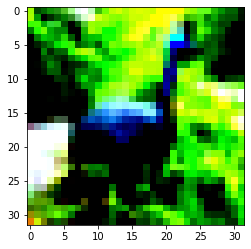

In [26]:
img, _ = cifar2[0]

plt.imshow(img.permute(1, 2, 0))
plt.show()

Oh, hello there. In order to call the model, we need to make the input have the right
dimensions. We recall that our model expects 3,072 features in the input, and that nn
works with data organized into batches along the zeroth dimension. So we need to
turn our 3 × 32 × 32 image into a 1D tensor and then add an extra dimension in the
zeroth position. We learned how to do this in chapter 3:

In [27]:
img_batch = img.view(-1).unsqueeze(0)

Now we’re ready to invoke our model:

In [28]:
out = model(img_batch)
out

tensor([[0.4507, 0.5493]], grad_fn=<SoftmaxBackward>)

So, we got probabilities! Well, we know we shouldn’t get too excited: the weights and
biases of our linear layers have not been trained at all. Their elements are initialized
randomly by PyTorch between –1.0 and 1.0. Interestingly, we also see `grad_fn` for the
output, which is the tip of the backward computation graph (it will be used as soon as
we need to backpropagate).

In addition, while we know which output probability is supposed to be which
(recall our `class_names` ), our network has no indication of that. Is the first entry “air-
plane” and the second “bird,” or the other way around? The network can’t even tell
that at this point. It’s the loss function that associates a meaning with these two num-
bers, after backpropagation. If the labels are provided as index 0 for “airplane” and
index 1 for “bird,” then that’s the order the outputs will be induced to take. Thus,
after training, we will be able to get the label as an index by computing the argmax of
the output probabilities: that is, the index at which we get the maximum probability.
Conveniently, when supplied with a dimension, `torch.max` returns the maximum ele-
ment along that dimension as well as the index at which that value occurs. In our case,
we need to take the max along the probability vector (not across batches), therefore,
dimension 1:

In [29]:
_, index = torch.max(out, dim=1)
index

tensor([1])

### 7.2.5 A loss for classifying
We just mentioned that the loss is what gives probabilities meaning. In chapters 5 and
6, we used mean square error (MSE) as our loss. We could still use MSE and make our
output probabilities converge to `[0.0, 1.0]` and `[1.0, 0.0]` . However, thinking about
it, we’re not really interested in reproducing these values exactly. Looking back at the
argmax operation we used to extract the index of the predicted class, what we’re really
interested in is that the first probability is higher than the second for airplanes and vice versa for birds. In other words, we want to penalize misclassifications rather than painstakingly penalize everything that doesn’t look exactly like a 0.0 or 1.0.

What we need to maximize in this case is the probability associated with the correct class, `out[class_index]` , where out is the output of softmax and `class_index` is a vector containing 0 for “airplane” and 1 for “bird” for each sample. This quantity—that is, the probability associated with the correct class—is referred to as the **likelihood** (of our model’s parameters, given the data). In other words, we want a loss function that is very high when the likelihood is low: so low that the alternatives have a higher probability. Conversely, the loss should be low when the likelihood is higher than the alternatives, and we’re not really fixated on driving the probability up to 1.

There’s a loss function that behaves that way, and it’s called **negative log likelihood**
(**NLL**). It has the expression `NLL = - sum(log(out_i[c_i]))` , where the sum is taken
over N samples and `c_i` is the correct class for sample `i`. Let’s take a look at figure 7.10, which shows the NLL as a function of predicted probability.

![](images/7.6.png)

The figure shows that when low probabilities are assigned to the data, the NLL grows to infinity, whereas it decreases at a rather shallow rate when probabilities are greater than 0.5. Remember that the NLL takes probabilities as input; so, as the likelihood grows, the other probabilities will necessarily decrease.

Summing up, our loss for classification can be computed as follows. For each sam-
ple in the batch:
1. Run the forward pass, and obtain the output values from the last (linear) layer.
2. Compute their softmax, and obtain probabilities.
3. Take the predicted probability corresponding to the correct class (the likelihood of the parameters). Note that we know what the correct class is because it’s a supervised problem—it’s our ground truth.
4. Compute its logarithm, slap a minus sign in front of it, and add it to the loss.

So, how do we do this in PyTorch? PyTorch has an `nn.NLLLoss` class. However (gotcha
ahead), as opposed to what you might expect, it does not take probabilities but rather
takes a tensor of log probabilities as input. It then computes the NLL of our model
given the batch of data. There’s a good reason behind the input convention: taking
the logarithm of a probability is tricky when the probability gets close to zero. The
workaround is to use `nn.LogSoftmax` instead of `nn.Softmax` , which takes care to make
the calculation numerically stable.

We can now modify our model to use `nn.LogSoftmax` as the output module:

In [30]:
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1))

Then we instantiate our NLL loss:

In [31]:
loss = nn.NLLLoss()

The loss takes the output of `nn.LogSoftmax` for a batch as the first argument and a
tensor of class indices (zeros and ones, in our case) as the second argument. We can
now test it with our birdie:

In [32]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss(out, torch.tensor([label]))

tensor(0.9774, grad_fn=<NllLossBackward>)

Ending our investigation of losses, we can look at how using cross-entropy loss
improves over MSE. In figure 7.11, we see that the cross-entropy loss has some slope when the prediction is off target (in the low-loss corner, the correct class is assigned a
predicted probability of 99.97%), while the MSE we dismissed at the beginning saturates much earlier and—crucially—also for very wrong predictions. The underlying
reason is that the slope of the MSE is too low to compensate for the flatness of the softmax function for wrong predictions. This is why the MSE for probabilities is not a
good fit for classification work.

![](images/7.7.png)

### 7.2.6 Training the classifier
We’re ready to bring back the training loop we wrote in chapter 5 and see
how it trains (the process is illustrated in figure 7.12):

In [35]:
import torch
import torch.nn as nn
from torch import optim

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Prints the loss for the last image. In the next chapter, we will improve our output to give an average over the entire epoch.        
print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

/home/hoai_tran/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


KeyboardInterrupt: 

![](images/7.8.png)

Looking more closely, we made a small change to the training loop. In chapter 5, we
had just one loop: over the epochs (recall that an epoch ends when all samples in the
training set have been evaluated). We figured that evaluating all 10,000 images in a
single batch would be too much, so we decided to have an inner loop where we evalu-
ate one sample at a time and backpropagate over that single sample.

By shuffling samples at each epoch and estimating the gradient on one or (preferably, for stability) a few samples at a time, we are effectively introducing randomness in our gradient descent. Remember **SGD**? It stands for stochastic gradient descent, and this is what the S is about: working on small batches (aka minibatches) of shuffled data.

Typically, minibatches are a constant size that we need to set prior to training, just
like the learning rate. These are called hyperparameters, to distinguish them from the
parameters of a model.

![](images/7.9.png)

In our training code, we chose minibatches of size 1 by picking one item at a time from
the dataset. The `torch.utils.data module` has a class that helps with shuffling and
organizing the data in minibatches: `DataLoader` . The job of a data loader is to sample
minibatches from a dataset, giving us the flexibility to choose from different sampling
strategies. A very common strategy is uniform sampling after shuffling the data at each
epoch. Figure 7.14 shows the data loader shuffling the indices it gets from the `Dataset`.

![](images/7.10.png)

Let’s see how this is done. At a minimum, the `DataLoader` constructor takes a `Dataset`
object as input, along with `batch_size` and a `shuffle` Boolean that indicates whether
the data needs to be shuffled at the beginning of each epoch:

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                            shuffle=True)

A `DataLoader` can be iterated over, so we can use it directly in the inner loop of our
new training code:

In [ ]:
import torch
import torch.nn as nn\
from torch import optim

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1))

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.NLLLoss()
n_epochs = 100

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))
    # Due to the shuffling, this now prints the loss for a random batch—clearly something we want to improve in chapter 8.

At each inner iteration, imgs is a tensor of size `64 × 3 × 32 × 32`—that is, a minibatch of `64 (32 × 32)` RGB images—while labels is a tensor of size 64 containing label indices.

We see that the loss decreases somehow, but we have no idea whether it’s low enough. Since our goal here is to correctly assign classes to images, and preferably do that on an independent dataset, we can compute the accuracy of our model on the validation set in terms of the number of correct classifications over the total:

In [ ]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f", correct / total)

Not a great performance, but quite a lot better than random. In our defense, our
model was quite a shallow classifier; it’s a miracle that it worked at all. It did because
our dataset is really simple—a lot of the samples in the two classes likely have system-
atic differences (such as the color of the background) that help the model tell birds
from airplanes, based on a few pixels.

We can certainly add some bling to our model by including more layers, which will
increase the model’s depth and capacity. One rather arbitrary possibility is

In [36]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2),
    nn.LogSoftmax(dim=1))

Here we are trying to taper the number of features more gently toward the output, in
the hope that intermediate layers will do a better job of squeezing information in
increasingly shorter intermediate outputs.

The combination of `nn.LogSoftmax` and `nn.NLLLoss` is equivalent to using `nn.CrossEntropyLoss` . This terminology is a particularity of PyTorch, as the
nn.NLLoss computes, in fact, the cross entropy but with log probability predictions as inputs where `nn.CrossEntropyLoss` takes scores (sometimes called logits). Technically, `nn.NLLLoss` is the cross entropy between the Dirac distribution, putting all mass on the target, and the predicted distribution given by the log probability inputs.

It is quite common to drop the last `nn.LogSoftmax` layer from the network and use
`nn.CrossEntropyLoss` as a loss. Let us try that:

In [37]:
model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2))

loss_fn = nn.CrossEntropyLoss()

Note that the numbers will be exactly the same as with `nn.LogSoftmax` and `nn.NLLLoss` . It’s just more convenient to do it all in one pass, with the only gotcha being that the output of our model will not be interpretable as probabilities (or log probabilities). We’ll need to explicitly pass the output through a softmax to obtain those.

Training this model and evaluating the accuracy on the validation set (0.802000)
lets us appreciate that a larger model bought us an increase in accuracy, but not that
much. The accuracy on the training set is practically perfect (0.998100). What is this
telling us? That we are overfitting our model in both cases. Our fully connected
model is finding a way to discriminate birds and airplanes on the training set by mem-
orizing the training set, but performance on the validation set is not all that great,
even if we choose a larger model.

PyTorch offers a quick way to determine how many parameters a model has
through the `parameters()` method of `nn.Model` (the same method we use to provide
the parameters to the optimizer). To find out how many elements are in each tensor
instance, we can call the `numel` method. Summing those gives us our total count.
Depending on our use case, counting parameters might require us to check whether a
parameter has `requires_grad` set to `True` , as well. We might want to differentiate the
number of trainable parameters from the overall model size. Let’s take a look at what
we have right now:

In [38]:
numel_list = [p.numel()
            for p in model.parameters()
            if p.requires_grad == True]
sum(numel_list), numel_list

NameError: name 'connected_model' is not defined

Wow, 3.7 million parameters! Not a small network for such a small input image, is it?
Even our first network was pretty large:

In [ ]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

The number of parameters in our first model is roughly half that in our latest model.
Well, from the list of individual parameter sizes, we start having an idea what’s
responsible: the first module, which has 1.5 million parameters. In our full network,
we had 1,024 output features, which led the first linear module to have 3 million
parameters. This shouldn’t be unexpected: we know that a linear layer computes `y =
weight * x + bias` , and if `x` has length 3,072 (disregarding the batch dimension for
simplicity) and `y` must have length 1,024, then the `weight` tensor needs to be of size
1,024 × 3,072 and the bias size must be 1,024. And 1,024 * 3,072 + 1,024 = 3,146,752,
as we found earlier. We can verify these quantities directly:

In [39]:
linear = nn.Linear(3072, 1024)
linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

What is this telling us? That our neural network won’t scale very well with the number
of pixels. What if we had a 1,024 × 1,024 RGB image? That’s 3.1 million input values.
Even abruptly going to 1,024 hidden features (which is not going to work for our clas-
sifier), we would have over **3 billion parameters**. Using 32-bit floats, we’re already at 12 GB of RAM, and we haven’t even hit the second layer, much less computed and stored
the gradients. That’s just not going to fit on most present-day GPUs.

### 7.2.7 The limits of going fully connected

Let’s reason about what using a linear module on a 1D view of our image entails—figure
7.15 shows what is going on. It’s like taking every single input value—that is, every single
component in our RGB image—and computing a linear combination of it with all the
other values for every output feature. On one hand, we are allowing for the combina-
tion of any pixel with every other pixel in the image being potentially relevant for our
task. On the other hand, we aren’t utilizing the relative position of neighboring or far-
away pixels, since we are treating the image as one big vector of numbers.

![](images/7.11.png)

An airplane flying in the sky captured in a 32 × 32 image will be very roughly similar to
a dark, cross-like shape on a blue background. A fully connected network as in figure
7.15 would need to learn that when pixel 0,1 is dark, pixel 1,1 is also dark, and so on,
that’s a good indication of an airplane. This is illustrated in the top half of figure 7.16.
However, shift the same airplane by one pixel or more as in the bottom half of the fig-
ure, and the relationships between pixels will have to be relearned from scratch: this
time, an airplane is likely when pixel 0,2 is dark, pixel 1,2 is dark, and so on. In more
technical terms, a fully connected network is not **translation invariant**. This means a
network that has been trained to recognize a Spitfire starting at position 4,4 will not
be able to recognize the exact same Spitfire starting at position 8,8. We would then have
to **augment** the dataset—that is, apply random translations to images during training—
so the network would have a chance to see Spitfires all over the image, and we would
need to do this for every image in the dataset (for the record, we could concatenate a transform from `torchvision.transforms` to do this transparently). However, this data
augmentation strategy comes at a cost: the number of hidden features—that is, of
parameters—must be large enough to store the information about all of these translated replicas.

![](images/7.12.png)

So, at the end of this chapter, we have a dataset, a model, and a training loop, and
our model learns. However, due to a mismatch between our problem and our network
structure, we end up overfitting our training data, rather than learning the general-
ized features of what we want the model to detect.

## 7.3 Conclusion
In this chapter, we have solved a simple classification problem from dataset, to model,
to minimizing an appropriate loss in a training loop. All of these things will be stan-
dard tools for your PyTorch toolbelt, and the skills needed to use them will be useful
throughout your PyTorch tenure.

We’ve also found a severe shortcoming of our model: we have been treating 2D
images as 1D data. Also, we do not have a natural way to incorporate the translation
invariance of our problem. In the next chapter, you’ll learn how to exploit the 2D
nature of image data to get much better results.

We could use what we have learned right away to process data without this translation
invariance. For example, using it on tabular data or the time-series data we met in chap-
ter 4, we can probably do great things already. To some extent, it would also be possible
to use it on text data that is appropriately represented.

## 7.4 Exercises
1. Use torchvision to implement random cropping of the data.
    * How are the resulting images different from the uncropped originals?
    * What happens when you request the same image a second time?
    * What is the result of training using randomly cropped images?
2. Switch loss functions (perhaps MSE).
    * Does the training behavior change?
3. Is it possible to reduce the capacity of the network enough that it stops overfitting?
    * How does the model perform on the validation set when doing so?

## 7.5 Summary
* Computer vision is one of the most extensive applications of deep learning.
* Several datasets of annotated images are publicly available; many of them can be accessed via `torchvision` .
* `Datasets` and `DataLoaders` provide a simple yet effective abstraction for loading and sampling datasets.
* For a classification task, using the softmax function on the output of a network produces values that satisfy the requirements for being interpreted as probabilities. The ideal loss function for classification in this case is obtained by using the output of softmax as the input of a non-negative log likelihood function. The combination of softmax and such loss is called cross entropy in PyTorch.
* Nothing prevents us from treating images as vectors of pixel values, dealing with them using a fully connected network, just like any other numerical data. However, doing so makes it much harder to take advantage of the spatial relationships in the data.
* Simple models can be created using `nn.Sequential`.